<a href="https://colab.research.google.com/github/amargauge26/GenraEq--cja-ssss/blob/main/MAIN_of_GENERA121_UPDATED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# Import necessary libraries
!pip install librosa numpy matplotlib scikit-learn tensorflow kagglehub

import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
import kagglehub  # For dataset download

# Download the dataset
path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")

# Define the path to the dataset
DATA_PATH = path
print("Path to dataset files:", DATA_PATH)

# Check the contents of the dataset directory
print(os.listdir(DATA_PATH))

# Check the contents of the Data directory
data_path = os.path.join(DATA_PATH, 'Data')
print(os.listdir(data_path))

# Define the correct path to the audio files
audio_data_path = os.path.join(data_path, 'genres_original')
print(os.listdir(audio_data_path))

# Define the feature extraction function
def extract_features(file_path):
    try:
        audio, sample_rate = librosa.load(file_path, duration=30)
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13)
        mfccs = np.mean(mfccs.T, axis=0)
        return mfccs
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Prepare lists to hold features and labels
features = []
labels = []

# Get the list of genres from the genres_original directory
genres = os.listdir(audio_data_path)

# Loop through each genre and extract features
for genre in genres:
    genre_dir = os.path.join(audio_data_path, genre)
    for file in os.listdir(genre_dir):
        if file.endswith(".wav"):
            file_path = os.path.join(genre_dir, file)
            mfccs = extract_features(file_path)
            if mfccs is not None:
                features.append(mfccs)
                labels.append(genre)

print("Features and labels extracted successfully!")

# Convert features and labels to NumPy arrays
features = np.array(features)
labels = np.array(labels)

Path to dataset files: /root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1
['Data']
['genres_original', 'features_30_sec.csv', 'features_3_sec.csv', 'images_original']
['disco', 'reggae', 'classical', 'jazz', 'country', 'pop', 'metal', 'hiphop', 'rock', 'blues']


<ipython-input-6-97a7f012bd3d>:36: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(file_path, duration=30)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error processing /root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1/Data/genres_original/jazz/jazz.00054.wav: 
Features and labels extracted successfully!


In [21]:
# Check if features and labels have been populated correctly
if features.size == 0 or labels.size == 0:
    print("Warning: No features or labels extracted. Check the audio files.")
else:
    # Encode the labels into integers
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, labels_encoded, test_size=0.2, random_state=42)

    print("Data prepared for training!")
    print("Training data shape:", X_train.shape)
    print("Testing data shape:", X_test.shape)

    # Reshape the features for CNN (adding a dummy dimension)
    X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # Define the CNN model for music genre classification
    model = models.Sequential([
        layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(128, kernel_size=3, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(len(label_encoder.classes_), activation='softmax')
    ])

    # Compile the model
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print("Model built successfully!")

    # Train the model
    history = model.fit(X_train_cnn, y_train, epochs=30, batch_size=32, validation_data=(X_test_cnn, y_test))
    print("Model trained successfully!")

    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(X_test_cnn, y_test, verbose=2)
    print(f"Test accuracy: {test_accuracy:.2f}")

Data prepared for training!
Training data shape: (799, 13)
Testing data shape: (200, 13)
Model built successfully!
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - accuracy: 0.1720 - loss: 3.7154 - val_accuracy: 0.4000 - val_loss: 1.7287
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.3197 - loss: 1.8859 - val_accuracy: 0.5050 - val_loss: 1.5382
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3774 - loss: 1.7296 - val_accuracy: 0.4700 - val_loss: 1.4901
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4371 - loss: 1.5855 - val_accuracy: 0.5100 - val_loss: 1.4344
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4735 - loss: 1.4879 - val_accuracy: 0.5150 - val_loss: 1.4131
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4610 - loss: 1.4606 - val_accuracy: 0.4950 - val_loss: 1.3387
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4756 - loss: 1.4419 - val_accuracy: 0.4650 - val_loss: 1.4124
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4746 - loss: 1.3959 - val_accuracy: 0.5100 - val_loss: 1.3251
E

In [22]:
y_pred = model.predict(X_test_cnn)
y_pred_classes = np.argmax(y_pred, axis=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [23]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))



Classification Report:
              precision    recall  f1-score   support

       blues       0.67      0.70      0.68        20
   classical       0.92      0.96      0.94        24
     country       0.31      0.33      0.32        15
       disco       0.32      0.29      0.30        21
      hiphop       0.40      0.21      0.28        19
        jazz       0.50      0.50      0.50        22
       metal       0.77      0.56      0.65        18
         pop       0.69      0.74      0.71        27
      reggae       0.22      0.50      0.31        12
        rock       0.44      0.36      0.40        22

    accuracy                           0.54       200
   macro avg       0.52      0.51      0.51       200
weighted avg       0.55      0.54      0.53       200



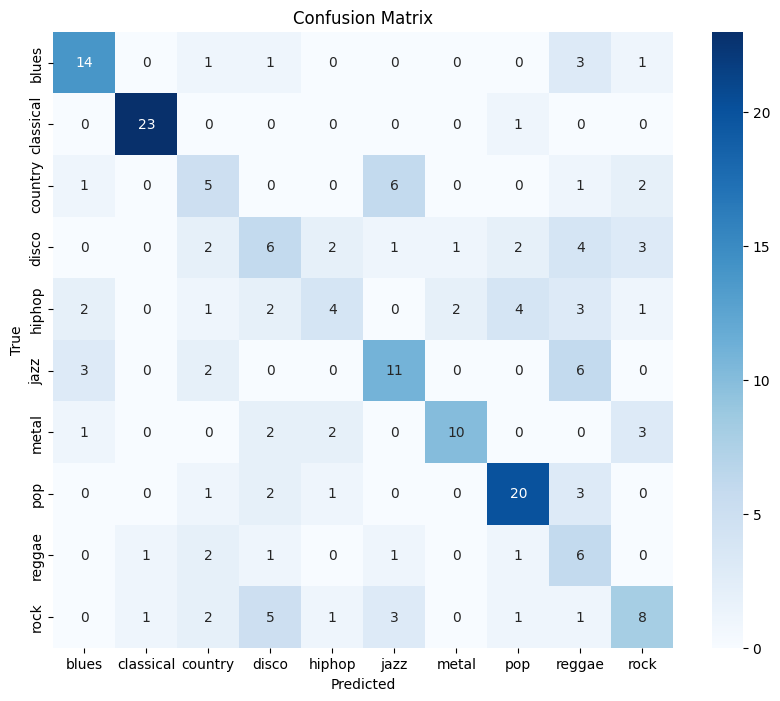

In [24]:
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

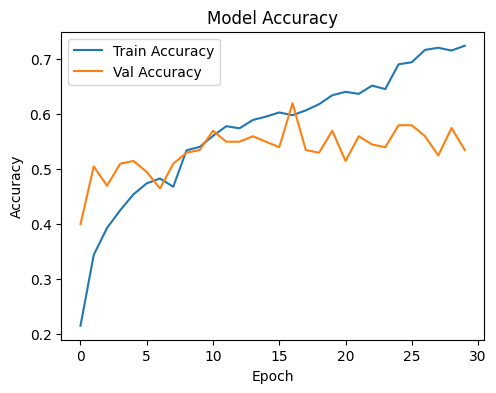

In [25]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

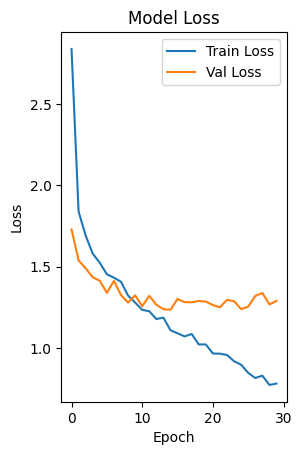

In [26]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.show()

In [27]:
# Save the model as an HDF5 file
model.save("model.h5")
print("Model saved as 'model.h5'")


Model saved as 'model.h5'


In [28]:
import pickle

# Save the model file path as a pickle file
with open("model_path.pkl", "wb") as f:
    pickle.dump("model.h5", f)
print("Model path saved as 'model_path.pkl'")


Model path saved as 'model_path.pkl'
